## ***In this assignment my task is to predict whether the customer of a financial institution exits or stays.***

# **Imports Essential Libraries**

In [1]:
import pandas as pd
import numpy as np

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import optuna

import warnings
warnings.filterwarnings('ignore')

# **Configs**

In [2]:
pd.set_option("display.max_columns", 200)
warnings.filterwarnings("ignore")

# **Loads the training and test datasets from the Kaggle input directory**

In [3]:
train_df= pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-2/test.csv')


train_df_copy = train_df.copy(deep=True)
test_df_copy = test_df.copy(deep=True)

# **Schema of data**

**Identify data types of different columns**

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                90000 non-null  int64  
 1   customer_id       90000 non-null  int64  
 2   last_name         90000 non-null  object 
 3   credit_score      80444 non-null  float64
 4   country           83979 non-null  object 
 5   gender            90000 non-null  object 
 6   age               90000 non-null  float64
 7   tenure            90000 non-null  int64  
 8   acc_balance       82743 non-null  float64
 9   prod_count        85137 non-null  float64
 10  has_card          90000 non-null  float64
 11  is_active         90000 non-null  float64
 12  estimated_salary  90000 non-null  float64
 13  exit_status       90000 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 9.6+ MB


# **Descriptive Statistics of numerical columns**

**Present descriptive statistics of numerical columns**

In [5]:
cols_to_drop = ['id', 'customer_id', 'last_name']

train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [6]:
train_df.describe()

,credit_score,age,tenure,acc_balance,prod_count,has_card,is_active,estimated_salary,exit_status
count,80444.000000,90000.000000,90000.000000,82743.000000,85137.000000,90000.000000,90000.000000,90000.000000,90000.000000
mean,656.497054,38.119533,5.017022,55456.732147,1.552932,0.754289,0.497178,112394.659679,0.211600
std,80.016856,8.855203,2.804813,62788.474236,0.548011,0.430510,0.499995,50360.440702,0.408445
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74430.360000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117505.070000,0.000000
75%,710.000000,42.000000,7.000000,119825.750000,2.000000,1.000000,1.000000,154874.787500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# **Identify The Missing Values**

In [7]:
print('Missing rows ratio')
train_df.isnull().sum()

Missing rows ratio


credit_score        9556
country             6021
gender                 0
age                    0
tenure                 0
acc_balance         7257
prod_count          4863
has_card               0
is_active              0
estimated_salary       0
exit_status            0
dtype: int64

In [8]:
test_df.isna().sum()

credit_score        3185
country             4606
gender                 0
age                    0
tenure                 0
acc_balance         5251
prod_count          1717
has_card               0
is_active              0
estimated_salary       0
dtype: int64

# **Handle The Missing Values**

In [9]:
from sklearn.impute import SimpleImputer

mean_col = ['credit_score', 'acc_balance', 'prod_count']
mode_col = ['country']

# For each mean column, impute and add indicator
for col in mean_col:
    imputer = SimpleImputer(strategy='mean', add_indicator=True)
    imputed = imputer.fit_transform(train_df[[col]])
    train_df[col] = imputed[:, 0]
    train_df[f"{col}_missing_indicator"] = imputed[:, 1]
    # Test set
    imputed_test = imputer.transform(test_df[[col]])
    test_df[col] = imputed_test[:, 0]
    test_df[f"{col}_missing_indicator"] = imputed_test[:, 1]

# For each mode column, impute and add indicator
for col in mode_col:
    imputer = SimpleImputer(strategy='most_frequent', add_indicator=True)
    imputed = imputer.fit_transform(train_df[[col]])
    train_df[col] = imputed[:, 0]
    train_df[f"{col}_missing_indicator"] = imputed[:, 1]
    # Test set
    imputed_test = imputer.transform(test_df[[col]])
    test_df[col] = imputed_test[:, 0]
    test_df[f"{col}_missing_indicator"] = imputed_test[:, 1]


# **Check for Missing Values Post Filling**

In [10]:
train_df.isna().sum()

credit_score                      0
country                           0
gender                            0
age                               0
tenure                            0
acc_balance                       0
prod_count                        0
has_card                          0
is_active                         0
estimated_salary                  0
exit_status                       0
credit_score_missing_indicator    0
acc_balance_missing_indicator     0
prod_count_missing_indicator      0
country_missing_indicator         0
dtype: int64

In [11]:
test_df.isna().sum()

credit_score                      0
country                           0
gender                            0
age                               0
tenure                            0
acc_balance                       0
prod_count                        0
has_card                          0
is_active                         0
estimated_salary                  0
credit_score_missing_indicator    0
acc_balance_missing_indicator     0
prod_count_missing_indicator      0
country_missing_indicator         0
dtype: int64

# **Identify And Handle Duplicate Tuples**

In [12]:
num_dups = train_df.shape[0] - train_df.drop_duplicates().shape[0]
print('Num of duplicates:', num_dups)
train_df = train_df.drop_duplicates()

Num of duplicates: 13


# **Identify And Handle Outliers**

We will use the IQR method to detect outliers and cap it to the IQR outlier threshholds, because it is a common practice in data cleanup tasks.

In [13]:
import pandas as pd

def robust_outlier_removal_inplace(df, cols, threshold=2):
    """
    Removes rows in-place from df that are outliers in at least `threshold` number of columns.
    Uses IQR method for numeric outlier detection.
    """
    outlier_flags = pd.DataFrame(index=df.index)

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_flags[col] = ~df[col].between(lower, upper)

    # Count how many columns each row is an outlier in
    outlier_counts = outlier_flags.sum(axis=1)

    # Keep only rows with fewer than `threshold` outlier flags
    df.drop(index=outlier_counts[outlier_counts >= threshold].index, inplace=True)

    return outlier_counts

# Usage
num_cols = ['credit_score', 'age', 'tenure', 'acc_balance', 'prod_count', 'estimated_salary']
outlier_counts = robust_outlier_removal_inplace(train_df, num_cols, threshold=2)

print(f"Cleaned train shape: {train_df.shape}")
print(outlier_counts.value_counts().sort_index())

Cleaned train shape: (89932, 15)
0    85764
1     4168
2       55
Name: count, dtype: int64


# **Graphical Representations for Visualization**

# **Distribution of Credit Score**

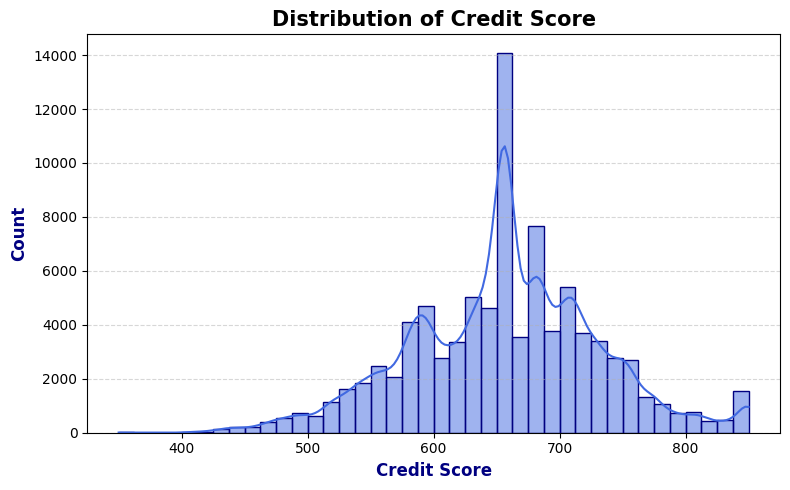

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(train_df['credit_score'], bins=40, kde=True, color='royalblue', edgecolor='navy')
plt.title('Distribution of Credit Score', fontsize=15, fontweight='bold')
plt.xlabel('Credit Score', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Count', fontsize=12, fontweight='bold', color='navy')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **Exit Rate by Country**

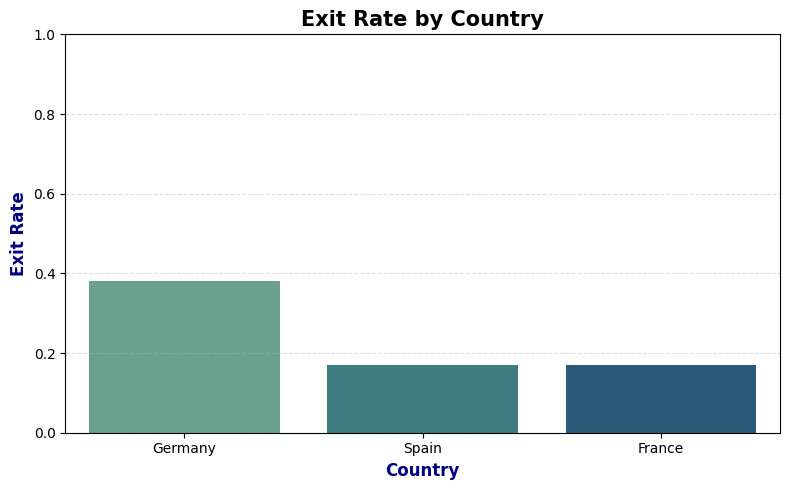

In [15]:
plt.figure(figsize=(8,5))
exit_by_country = train_df.groupby('country')['exit_status'].mean().sort_values(ascending=False)
sns.barplot(x=exit_by_country.index, y=exit_by_country.values, palette='crest')
plt.title('Exit Rate by Country', fontsize=15, fontweight='bold')
plt.xlabel('Country', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Exit Rate', fontsize=12, fontweight='bold', color='navy')
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Age Distribution by Exit Status**

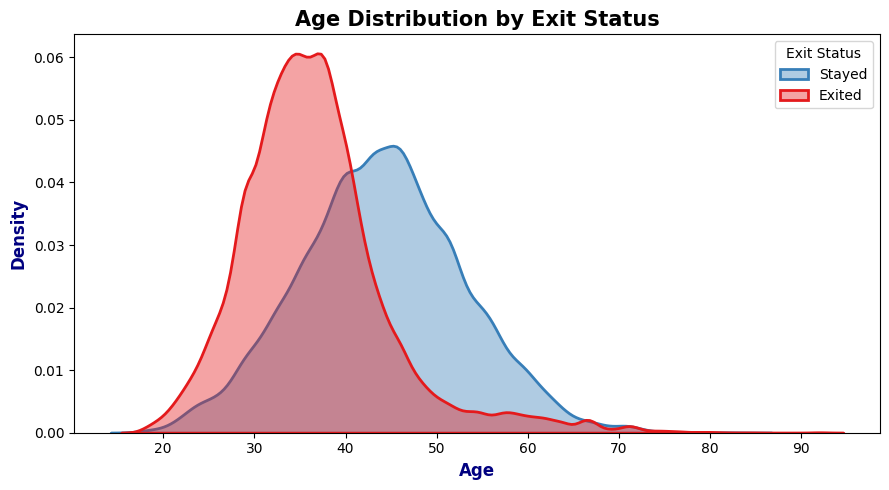

In [16]:
plt.figure(figsize=(9,5))
sns.kdeplot(data=train_df, x='age', hue='exit_status', fill=True, 
            common_norm=False, palette='Set1', alpha=0.4, linewidth=2)
plt.title('Age Distribution by Exit Status', fontsize=15, fontweight='bold')
plt.xlabel('Age', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Density', fontsize=12, fontweight='bold', color='navy')
plt.legend(title='Exit Status', labels=['Stayed', 'Exited'])
plt.tight_layout()
plt.show()

# **Pairplot for Key Features Colored by Exit Status**
Shows pairwise relationships among features (helpful for spotting trends/clusters).

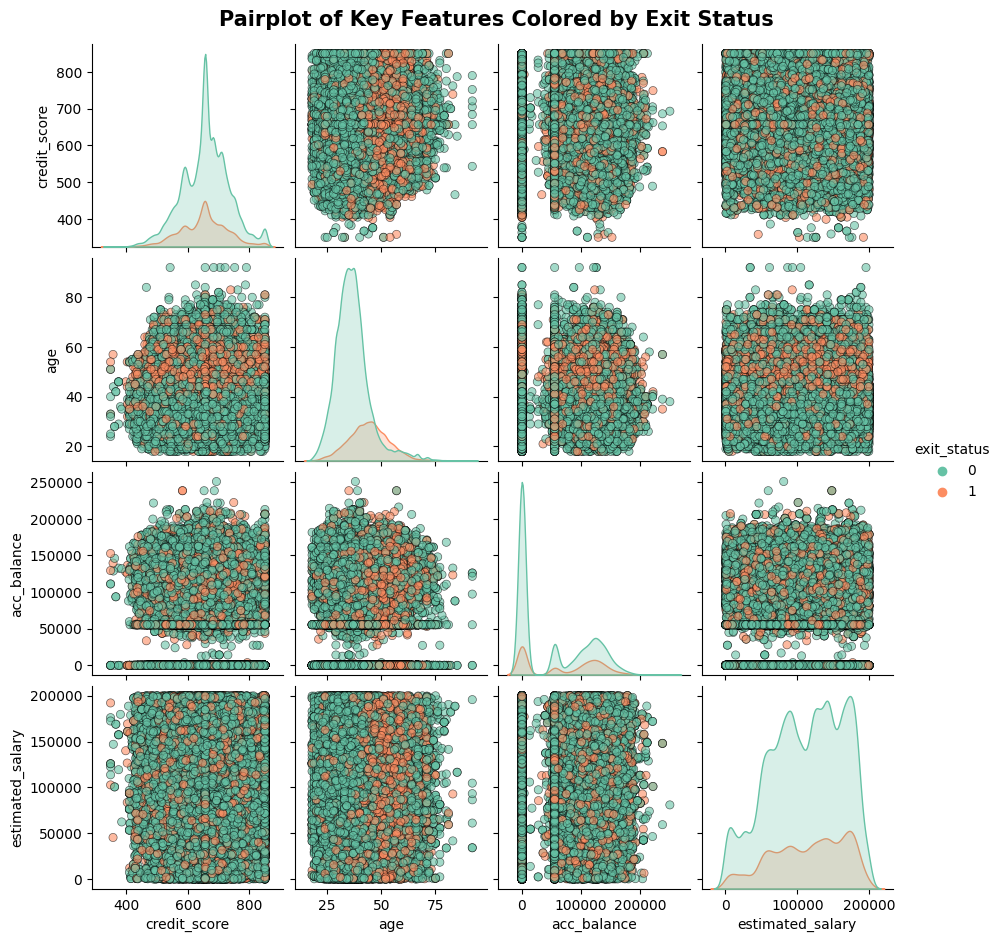

In [17]:

key_features = ['credit_score', 'age', 'acc_balance', 'estimated_salary', 'exit_status']
sns.pairplot(
    train_df[key_features], 
    hue='exit_status',
    palette='Set2',
    plot_kws={'alpha': 0.6, 's': 35, 'edgecolor': 'k'},
    diag_kind='kde',
    height=2.3
)
plt.suptitle('Pairplot of Key Features Colored by Exit Status', fontsize=15, fontweight='bold', y=1.02)
plt.show()


# **Violin Plot: Age by Gender & Exit Status**
Shows age distribution across gender for stayed/exited classes.

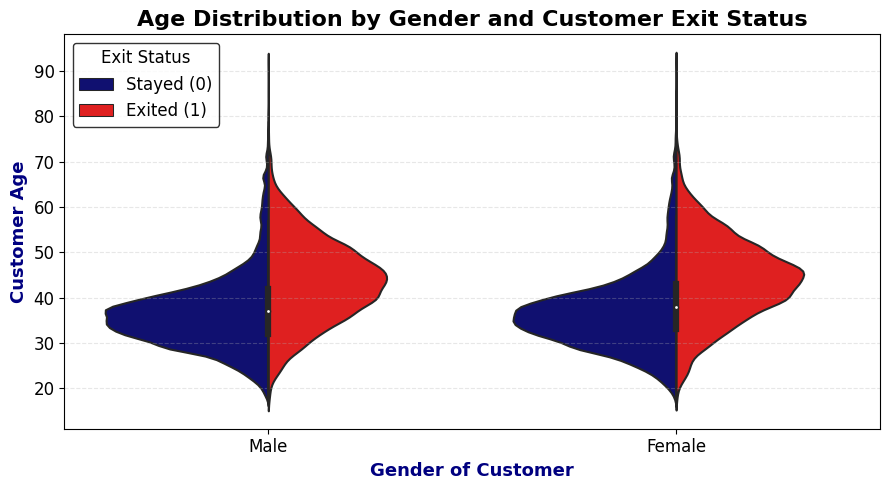

In [18]:
plt.figure(figsize=(9,5))

# Custom palette: blue for "Stayed (0)", orange for "Exited (1)"
custom_palette = {0: 'navy', 1: 'red'}

sns.violinplot(
    data=train_df, 
    x='gender', 
    y='age', 
    hue='exit_status', 
    split=True, 
    palette=custom_palette
)
plt.title('Age Distribution by Gender and Customer Exit Status', fontsize=16, fontweight='bold')
plt.xlabel('Gender of Customer', fontsize=13, fontweight='bold', color='navy')
plt.ylabel('Customer Age', fontsize=13, fontweight='bold', color='navy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust legend for clarity
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles, 
    labels=['Stayed (0)', 'Exited (1)'],
    title='Exit Status', 
    title_fontsize=12,
    fontsize=12,
    loc='upper left',
    frameon=True,
    edgecolor='black'
)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# **Faceted Bar Plot: Exit Rate by Tenure (0–10)**
Shows exit rate for each tenure year (discrete bar for each year).

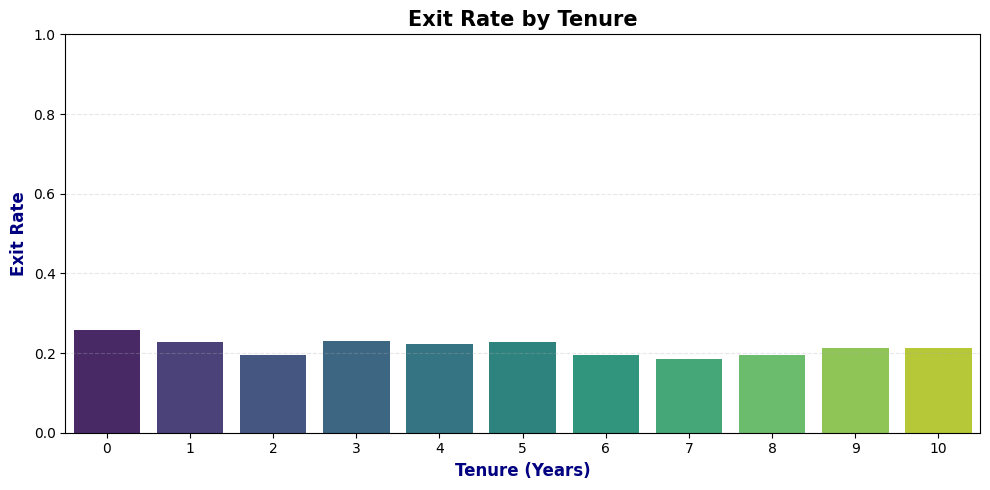

In [19]:

plt.figure(figsize=(10,5))
tenure_exit = train_df.groupby('tenure')['exit_status'].mean()
sns.barplot(x=tenure_exit.index, y=tenure_exit.values, palette='viridis')
plt.title('Exit Rate by Tenure', fontsize=15, fontweight='bold')
plt.xlabel('Tenure (Years)', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Exit Rate', fontsize=12, fontweight='bold', color='navy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# **Boxplot of Account Balance by Exit Status**

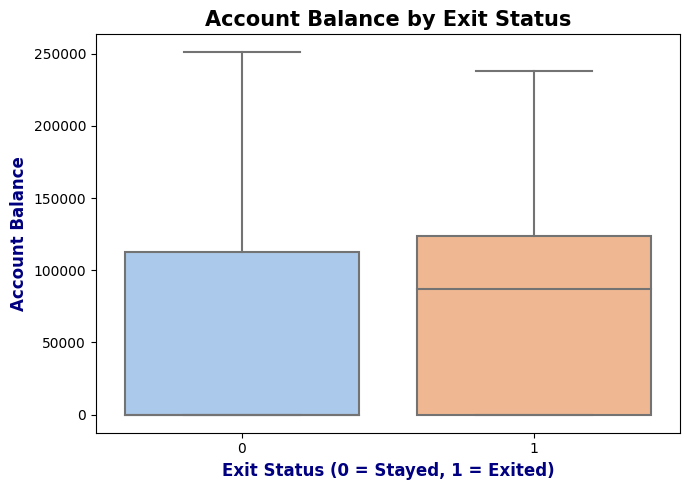

In [20]:
plt.figure(figsize=(7,5))
sns.boxplot(data=train_df, x='exit_status', y='acc_balance', palette='pastel')
plt.title('Account Balance by Exit Status', fontsize=15, fontweight='bold')
plt.xlabel('Exit Status (0 = Stayed, 1 = Exited)', fontsize=12, fontweight='bold', color='navy')
plt.ylabel('Account Balance', fontsize=12, fontweight='bold', color='navy')
plt.tight_layout()
plt.show()


# **Correlation Heatmap (Numerical Features)**

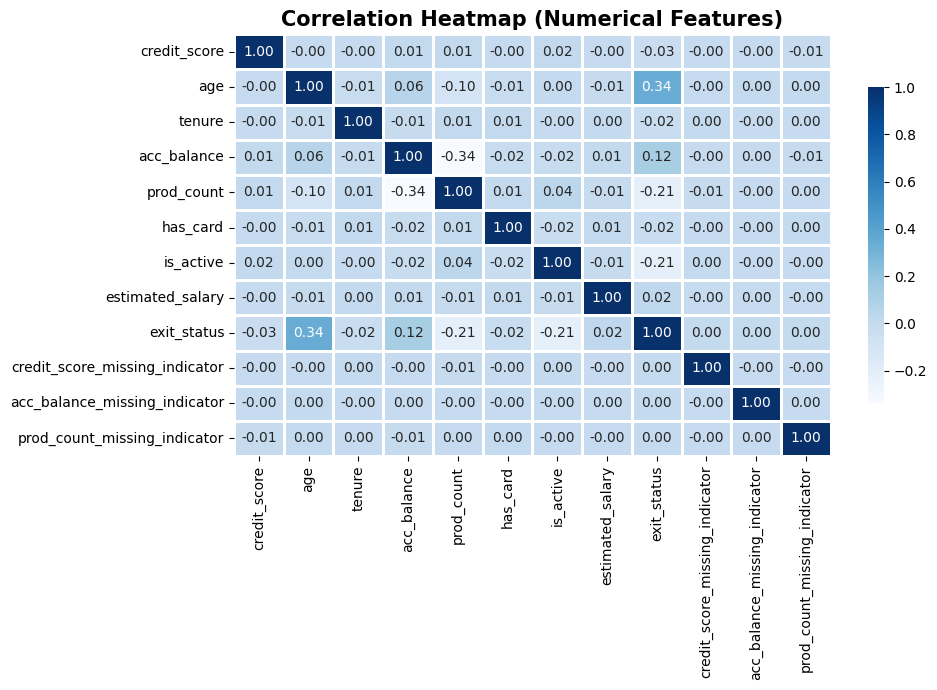

In [21]:

plt.figure(figsize=(10,7))
corr = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', linewidths=1, cbar_kws={"shrink": 0.75})
plt.title('Correlation Heatmap (Numerical Features)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()


# **Categorizing Features for Encoding + Scaling**

# **Data Preprocessing Pipeline Setup**

* Feature grouping
* Numeric scaling
* Categorical encoding
* Pass missing flags
* Remove constant cols
* Model-pipeline dict
* Split data

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

import tempfile
cachedir1 = tempfile.mkdtemp()
cachedir2 = tempfile.mkdtemp()

numerical_cols = ['credit_score', 'age', 'tenure', 'acc_balance', 'prod_count', 'estimated_salary', 'has_card', 'is_active']
missing_indicator_cols = ['credit_score_missing_indicator', 'country_missing_indicator', 'acc_balance_missing_indicator', 'prod_count_missing_indicator']
categorical_cols = ['country', 'gender']

numeric_transformer = StandardScaler()
poly_features = PolynomialFeatures(degree=2, interaction_only=True)

numeric_pipeline = Pipeline([
    ('scaler', numeric_transformer),
    # ('poly', poly_features)
])

one_hot_categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

preprocessor_one_hot = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numerical_cols),
        ('cat', one_hot_categorical_transformer, categorical_cols),
        ('missing_indicator', 'passthrough', missing_indicator_cols)
    ]
)

var_thresh_preprocessor_one_hot = Pipeline(steps=[
        ('preprocessor', preprocessor_one_hot),
        ('var_thresh', VarianceThreshold(threshold=0.0))
    ],
    memory=cachedir1
)

preprocessor_pipeline_dict = {
    'logistic_regression': var_thresh_preprocessor_one_hot,
    'perceptron': var_thresh_preprocessor_one_hot,
    'random_forest_classifier': var_thresh_preprocessor_one_hot,
    'gradient_boosting_classifier': var_thresh_preprocessor_one_hot,
    'ada_boost_classifier': var_thresh_preprocessor_one_hot,
    'decision_tree_classifier': var_thresh_preprocessor_one_hot,
    'knn_classifier': var_thresh_preprocessor_one_hot,
    'XGBoost': var_thresh_preprocessor_one_hot,
    'LightGBM': var_thresh_preprocessor_one_hot,
    'CatBoost': var_thresh_preprocessor_one_hot
}

X_train = train_df.drop(columns='exit_status')
y_train = train_df['exit_status']

X_test = test_df

# **Fitting the Preprocessing Pipeline and Extracting Feature Names**

In [23]:
var_thresh_preprocessor_one_hot.fit(X_train)
feature_names = var_thresh_preprocessor_one_hot.get_feature_names_out()


# **Defining Models, Initializing Fitted Models & Model Metric Dictionary**

# **10 Models**

1) Logistic Regression

2) Perceptron

3) Random Forest Classifier

4) Gradient Boosting Classifier

5) ADA Boost Classifier

6) Decision Tree Classifier

7) KNN Classifier

8) XGBoost

9) LightGBM

10) CatBoost

In [24]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


model_head_dict = {
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'perceptron': Perceptron(random_state=42),
    'random_forest_classifier': RandomForestClassifier(random_state=42),
    'gradient_boosting_classifier': GradientBoostingClassifier(random_state=42),
    'ada_boost_classifier': AdaBoostClassifier(random_state=42),
    'decision_tree_classifier': DecisionTreeClassifier(random_state=42),
    'knn_classifier': KNeighborsClassifier(n_neighbors=3),   
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(
    verbose=-1,             # suppresses logs
    n_jobs=-1,              # use all available CPU cores
    random_state=42,        # reproducibility
    class_weight='balanced'), # helpful for imbalanced classes
    "CatBoost": CatBoostClassifier(verbose=0)

}

model_dict = {
    m_name:
    Pipeline(steps=[
        ('pre', preprocessor_pipeline_dict[m_name]),
        ('model', m_head)
    ])
    for m_name, m_head in model_head_dict.items()
}

# **Custom Data Oversampling Function for Imbalanced Datasets**

In [25]:
def data_oversampler(X, y, group_info):
    overall_oversampled_indices = []
    for gi in group_info:
        grp_identify_func, n_times = gi
        group_index = list(y[grp_identify_func(y)].index)
        num_of_group_members = len(group_index)
        group_oversampled_indices = np.random.choice(group_index, size=int(num_of_group_members*n_times), replace=True)
        overall_oversampled_indices.extend(group_oversampled_indices)
    total_indices = list(y.index) + overall_oversampled_indices
    np.random.shuffle(total_indices)
    X_oversampled = X.loc[total_indices].reset_index(drop=True)
    y_oversampled = y.loc[total_indices].reset_index(drop=True)
    return X_oversampled, y_oversampled

# **Training Model and Storing the Fitted Model and its Performance Metric**

In [26]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_score_dict = {
    'model_name': [],
    'f1_score': [],
    'AUC_score': []
}

best_model = None
best_score = -np.inf
best_model_name = None

for model_name, model_pipeline in model_dict.items():
    
    fold_scores = []
    fold_models = []
    fold_auc_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = clone(model_pipeline)
        group_info = [(lambda x: x==1, 1.4)]
        X_tr_samp, y_tr_samp = data_oversampler(X_tr, y_tr, group_info)
        model.fit(X_tr_samp, y_tr_samp)

        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)
        fold_scores.append(score)
        fold_models.append(model)
        fold_auc_scores.append(auc)

    
    best_score = np.max(fold_scores)
    best_auc = np.max(fold_auc_scores) * 100 
    best_fold_idx = np.argmax(fold_scores)
    best_fold_model = fold_models[best_fold_idx]

    # Set the best fitted model as the model in the model_dict
    model_dict[model_name] = best_fold_model
    auc = roc_auc_score(y_val, y_pred)
    print(f"{model_name} | F1 Score: {best_score:.4f} | AUC Score: {best_auc:.2f} %")
    
    model_score_dict['model_name'].append(model_name)
    model_score_dict['f1_score'].append(best_score)
    model_score_dict['AUC_score'].append(best_auc)

logistic_regression | F1 Score: 0.5873 | AUC Score: 74.43 %
perceptron | F1 Score: 0.4940 | AUC Score: 68.50 %
random_forest_classifier | F1 Score: 0.6240 | AUC Score: 75.08 %
gradient_boosting_classifier | F1 Score: 0.6680 | AUC Score: 80.16 %
ada_boost_classifier | F1 Score: 0.6533 | AUC Score: 79.33 %
decision_tree_classifier | F1 Score: 0.5223 | AUC Score: 69.68 %
knn_classifier | F1 Score: 0.5610 | AUC Score: 73.32 %
XGBoost | F1 Score: 0.6555 | AUC Score: 78.92 %
LightGBM | F1 Score: 0.6485 | AUC Score: 80.72 %
CatBoost | F1 Score: 0.6595 | AUC Score: 79.12 %


In [27]:
pd.DataFrame(model_score_dict).sort_values(by='f1_score', ascending=False)

,model_name,f1_score,AUC_score
3,gradient_boosting_classifier,0.668037,80.159506
9,CatBoost,0.659490,79.123832
7,XGBoost,0.655518,78.920442
4,ada_boost_classifier,0.653281,79.326170
8,LightGBM,0.648532,80.724855
2,random_forest_classifier,0.623969,75.077592
0,logistic_regression,0.587255,74.432110
6,knn_classifier,0.561046,73.322613
5,decision_tree_classifier,0.522260,69.679564
1,perceptron,0.494008,68.502342


# **Hyperparameter Tuning**

* Tuning Gradient Boosting Classifier
* Tuning XGBoost
* Tuning LightGBM
* Tuning CatBoost


# **Tuning Gradient Boosting Classifier**

In [28]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# 1. Optuna objective function for GBM with pipeline, oversampling, and CV
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 740, 900),
        'max_depth': 5,
        'learning_rate': trial.suggest_float('learning_rate', 0.011, 0.013),
        'subsample': trial.suggest_float('subsample', 0.65, 0.75),
        'min_samples_split': trial.suggest_int('min_samples_split', 92, 107),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 33, 35),
        'max_features': None,
    }
    clf = Pipeline([
        ('pre', var_thresh_preprocessor_one_hot),
        ('model', GradientBoostingClassifier(**params, random_state=42))
    ])
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        group_info = [(lambda x: x==1, 1.4)]
        X_tr_samp, y_tr_samp = data_oversampler(X_tr, y_tr, group_info)
        clf.fit(X_tr_samp, y_tr_samp)
        y_pred = clf.predict(X_val)
        score = f1_score(y_val, y_pred)
        scores.append(score)
    return np.mean(scores)

# 2. Run Optuna search
# Run Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1, n_jobs=-1, show_progress_bar=True)  # Use all CPUs
#  print("Best Gradient Boosting Hyperparameters:", study.best_params)

# ... your Optuna code above ...

# Show top 10 parameter sets found by Optuna
df_trials = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df_trials_sorted = df_trials.sort_values("value", ascending=False)
#     print("\nTop 10 parameter sets (sorted by F1):")
for idx, row in df_trials_sorted.head(3).iterrows():
    trial_num = int(row['number'])
    f1 = row['value']
    params = {col.replace('params_', ''): row[col] for col in df_trials_sorted.columns if col.startswith('params_')}
#    print(f"Trial {trial_num} | F1: {f1:.4f} | Params: {params}")

# 3. Evaluate best GBM (CV F1 and AUC, log into model_score_dict)
best_gb_params = study.best_params
best_gb_pipeline = Pipeline([
    ('pre', var_thresh_preprocessor_one_hot),
    ('model', GradientBoostingClassifier(**best_gb_params, random_state=42))
])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_f1_scores = []
fold_auc_scores = []
fold_models = []
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    group_info = [(lambda x: x==1, 1.4)]
    X_tr_samp, y_tr_samp = data_oversampler(X_tr, y_tr, group_info)
    best_gb_pipeline.fit(X_tr_samp, y_tr_samp)
    y_pred = best_gb_pipeline.predict(X_val)
    try:
        y_proba = best_gb_pipeline.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_proba)
    except:
        auc = roc_auc_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    fold_f1_scores.append(f1)
    fold_auc_scores.append(auc)
    fold_models.append(best_gb_pipeline)
best_f1 = np.mean(fold_f1_scores)
best_auc = np.max(fold_auc_scores) * 100
best_fold_idx = np.argmax(fold_f1_scores)
best_model = fold_models[best_fold_idx]


print(f"Tuned Gradient Boosting Classifier | F1 Score: {best_f1:.4f} | AUC Score: {best_auc:.2f} %")

# 4. Add results to model_score_dict and optionally model_dict
model_score_dict['model_name'].append("Tuned_Gradient_Boosting_Classifier")
model_score_dict['f1_score'].append(best_f1)
model_score_dict['AUC_score'].append(best_auc)
# Optionally, also save to model_dict for later use
model_dict['Tuned_Gradient_Boosting_Classifier'] = best_model


  0%|          | 0/1 [00:00<?, ?it/s]

Tuned Gradient Boosting Classifier | F1 Score: 0.6542 | AUC Score: 88.95 %


# **Tuning XGBoost**

In [29]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.base import clone



def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.06),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 11),
        'subsample': trial.suggest_uniform('subsample', 0.55, 0.85),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.78),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 0.05), 
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 0.4),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-6, 0.2),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.7, 3.2),
        'random_state': 42,
        'n_jobs': -1,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Full pipeline: preprocessor + XGBClassifier
    from xgboost import XGBClassifier
    from sklearn.pipeline import Pipeline

    pipe = Pipeline([
        ('pre', preprocessor_one_hot),
        ('model', XGBClassifier(**params))
    ])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1s = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        f1s.append(f1_score(y_val, y_pred))
    return np.mean(f1s)

# Run Optuna
# Run Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

# Get top 10 trials
# Show top 10 parameter sets found by Optuna
df_trials = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df_trials_sorted = df_trials.sort_values("value", ascending=False)
#    print("\nTop 10 parameter sets (sorted by F1):")
for idx, row in df_trials_sorted.head(3).iterrows():
    trial_num = int(row['number'])
    f1 = row['value']
    params = {col.replace('params_', ''): row[col] for col in df_trials_sorted.columns if col.startswith('params_')}
#    print(f"Trial {trial_num} | F1: {f1:.4f} | Params: {params}")

# Best parameters
best_params = study.best_params
# print("Best parameters found by Optuna:", best_params)

# Train best model on ALL train data
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

best_xgb_pipe = Pipeline([
    ('pre', preprocessor_one_hot),
    ('model', XGBClassifier(**{**best_params, 'random_state':42, 'n_jobs':-1, 'use_label_encoder':False, 'eval_metric':'logloss'}))
])

best_xgb_pipe.fit(X_train, y_train)

# Cross-validated F1 and AUC (with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1s, aucs = [], []
for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    best_xgb_pipe.fit(X_tr, y_tr)
    y_pred = best_xgb_pipe.predict(X_val)
    y_proba = best_xgb_pipe.predict_proba(X_val)[:, 1]
    f1s.append(f1_score(y_val, y_pred))
    aucs.append(roc_auc_score(y_val, y_proba))

mean_f1 = np.max(f1s)
mean_auc = np.mean(aucs) * 100

# Update your dictionaries
model_dict['Tuned_XGBoost'] = best_xgb_pipe
model_score_dict['model_name'].append('Tuned_XGBoost')
model_score_dict['f1_score'].append(mean_f1)
model_score_dict['AUC_score'].append(mean_auc)

print(f"\nTuned XGBoost | Mean 5-Fold F1: {mean_f1:.4f} | Mean 5-Fold AUC: {mean_auc:.2f} %")


  0%|          | 0/50 [00:00<?, ?it/s]


Tuned XGBoost | Mean 5-Fold F1: 0.6569 | Mean 5-Fold AUC: 88.21 %


# **Tuning LightGBM**

In [30]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import warnings
import os
import sys

# Helper to suppress stdout/stderr and warnings
class SuppressStdoutStderr(object):
    def __enter__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for _ in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)
    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

optuna_results = []

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'device_type': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbosity': -1    # <--- Suppress LightGBM logging
    }
    lgbm_pipeline = Pipeline([
        ('pre', preprocessor_pipeline_dict['LightGBM']),
        ('model', LGBMClassifier(**params))
    ])
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    aucs = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        group_info = [(lambda x: x==1, 1.4)]
        X_tr_samp, y_tr_samp = data_oversampler(X_tr, y_tr, group_info)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with SuppressStdoutStderr():
                lgbm_pipeline.fit(X_tr_samp, y_tr_samp)
                y_pred = lgbm_pipeline.predict(X_val)
                y_proba = lgbm_pipeline.predict_proba(X_val)[:,1]
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        scores.append(f1)
        aucs.append(auc)
    mean_f1 = np.mean(scores)
    mean_auc = np.mean(aucs)
    optuna_results.append((trial.number, params, mean_f1, mean_auc))
    return mean_f1

# Run Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)  # Increase n_trials as needed

# Show top 10 trials by F1
optuna_results.sort(key=lambda x: -x[2])
#print("\nTop 10 Optuna LGBM Trials (by F1):")
for idx, (trial_no, params, f1, auc) in enumerate(optuna_results[:0], 1):
    print(f"Rank {idx}: Trial {trial_no} | F1: {f1:.4f} | AUC: {auc*100:.2f}%")
    #print(f"  Params: {params}")

# Use best params for final model
best_params = study.best_params
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['n_jobs'] = -1
best_params['device_type'] = 'gpu'
best_params['gpu_platform_id'] = 0
best_params['gpu_device_id'] = 0
best_params['verbosity'] = -1

final_lgbm_pipeline = Pipeline([
    ('pre', preprocessor_pipeline_dict['LightGBM']),
    ('model', LGBMClassifier(**best_params))
])
group_info = [(lambda x: x==1, 1.4)]
X_train_samp, y_train_samp = data_oversampler(X_train, y_train, group_info)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with SuppressStdoutStderr():
        final_lgbm_pipeline.fit(X_train_samp, y_train_samp)

# 5-fold CV for final tuned model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
auc_scores = []
for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    group_info = [(lambda x: x==1, 1.4)]
    X_tr_samp, y_tr_samp = data_oversampler(X_tr, y_tr, group_info)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with SuppressStdoutStderr():
            final_lgbm_pipeline.fit(X_tr_samp, y_tr_samp)
            y_pred = final_lgbm_pipeline.predict(X_val)
            y_proba = final_lgbm_pipeline.predict_proba(X_val)[:,1]
    f1_scores.append(f1_score(y_val, y_pred))
    auc_scores.append(roc_auc_score(y_val, y_proba))

mean_f1 = np.max(f1_scores)
mean_auc = np.mean(auc_scores) * 100

print(f"\nTuned LightGBM | 5-Fold Mean F1: {mean_f1:.4f} | Mean AUC: {mean_auc:.2f}%")

# Update model_dict and model_score_dict
model_dict['Tuned_LightGBM'] = final_lgbm_pipeline
model_score_dict['model_name'].append('Tuned_LightGBM')
model_score_dict['f1_score'].append(mean_f1)
model_score_dict['AUC_score'].append(mean_auc)


  0%|          | 0/10 [00:00<?, ?it/s]


Tuned LightGBM | 5-Fold Mean F1: 0.6426 | Mean AUC: 87.99%


# **Tuning CatBoost**

In [31]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# List of your categorical columns (string/object types)
cat_features = [col for col in X_train.columns if str(X_train[col].dtype) == 'object']

def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.8, 4.0, log=True),
        "thread_count": -1,
        "eval_metric": "F1",
        "random_state": 42,
        "verbose": 0,
        "loss_function": "Logloss"
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, cat_features=cat_features, eval_set=(X_val, y_val), use_best_model=True)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred)
        f1_scores.append(score)
    return np.mean(f1_scores)

# Run Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(catboost_objective, n_trials=5, n_jobs=-1, show_progress_bar=True)

#print("Best CatBoost params:", study.best_params)
#print("Best F1 (CV):", study.best_value)

# Train best CatBoost on all data
best_cb_params = study.best_params
best_cb_params['thread_count'] = -1
best_cb_params['random_state'] = 42
best_cb_params['verbose'] = 0
best_cb_params['loss_function'] = "Logloss"
best_cb_params['eval_metric'] = "F1"

catboost_model = CatBoostClassifier(**best_cb_params)
catboost_model.fit(X_train, y_train, cat_features=cat_features)

# Cross-validated F1 and AUC for best CatBoost
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cb_f1_scores = []
cb_auc_scores = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    catboost_model.fit(X_tr, y_tr, cat_features=cat_features)
    y_pred = catboost_model.predict(X_val)
    y_proba = catboost_model.predict_proba(X_val)[:, 1]
    cb_f1_scores.append(f1_score(y_val, y_pred))
    cb_auc_scores.append(roc_auc_score(y_val, y_proba))

mean_cb_f1 = np.max(cb_f1_scores)
mean_cb_auc = np.mean(cb_auc_scores) * 100

# Add to model_score_dict and model_dict
model_score_dict['model_name'].append('Tuned_CatBoost')
model_score_dict['f1_score'].append(mean_cb_f1)
model_score_dict['AUC_score'].append(mean_cb_auc)
model_dict['Tuned_CatBoost'] = catboost_model

print(f"Tuned CatBoost | Mean F1: {mean_cb_f1:.4f} | Mean AUC: {mean_cb_auc:.2f} %")



  0%|          | 0/5 [00:00<?, ?it/s]

Tuned CatBoost | Mean F1: 0.6547 | Mean AUC: 88.34 %


# **Comparing Model Performance**

In [32]:
model_perf_df = pd.DataFrame(model_score_dict)
model_perf_df = model_perf_df.sort_values(by=['f1_score'], axis=0, ascending=False)
model_perf_df

,model_name,f1_score,AUC_score
3,gradient_boosting_classifier,0.668037,80.159506
9,CatBoost,0.659490,79.123832
11,Tuned_XGBoost,0.656875,88.213288
7,XGBoost,0.655518,78.920442
13,Tuned_CatBoost,0.654748,88.341687
10,Tuned_Gradient_Boosting_Classifier,0.654217,88.947416
4,ada_boost_classifier,0.653281,79.326170
8,LightGBM,0.648532,80.724855
12,Tuned_LightGBM,0.642571,87.994158
2,random_forest_classifier,0.623969,75.077592


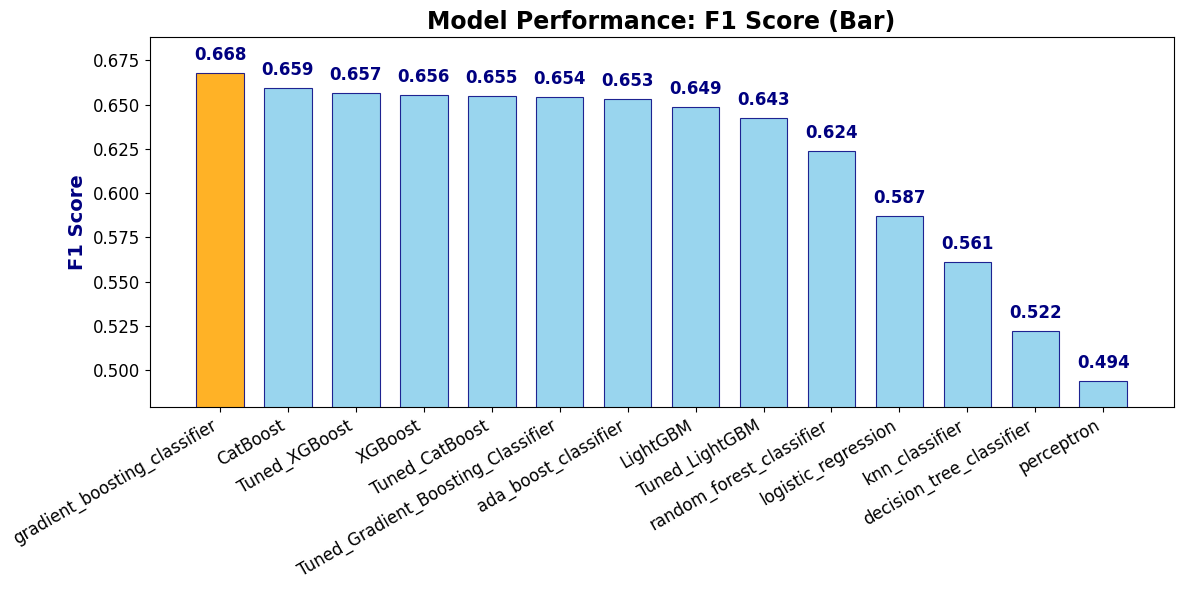

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame with 'model_name' and 'f1_score' columns
df = model_perf_df.sort_values(by="f1_score", ascending=False).reset_index(drop=True)

models = df['model_name']
f1_scores = df['f1_score']
x = np.arange(len(models))

# Detect highest F1 score index
max_idx = f1_scores.idxmax()
colors = ['orange' if i == max_idx else 'skyblue' for i in df.index]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(
    x, f1_scores,
    color=colors,
    width=0.7,
    alpha=0.85,
    edgecolor='navy',     # Border color
    linewidth=.8           # Border thickness
)

# Y-axis label
ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold', color='navy')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(min(f1_scores)*0.97, max(f1_scores)*1.03)

# Annotate each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005,
            f'{yval:.3f}',
            ha='center', va='bottom',
            fontsize=12, color='navy', fontweight='bold')

plt.title('Model Performance: F1 Score (Bar)', fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()


# **Selecting Final Model**

In [34]:
best_model_notebook_name = model_perf_df.iloc[0, 0]
print('Best Model of the Notebook is:', best_model_notebook_name)
best_model_notebook = model_dict[best_model_notebook_name]

Best Model of the Notebook is: gradient_boosting_classifier


# **Predicting Test Dataset and Submitting Prediction**

In [35]:
y_pred = best_model_notebook.predict(X_test)


submission_df = pd.DataFrame({
    'id': list(range(0, len(y_pred))),
    'exit_status': y_pred
})

submission_df
submission_df.to_csv('submission.csv', index=False)